In [1]:
import glob
import numpy as np
from pathlib import Path
from math import floor
import timeit
import os
import random
import matplotlib.pyplot as plt

pdb_path = "/data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/metrics"
tp_files = list(Path(pdb_path).rglob("*tp.npy"))

tp_files_str = [str(os.path.basename(path)) for path in tp_files]
pfam_ids = [tp_str[5:12] for tp_str in tp_files_str] 
pdb_ids = [tp_str[:4] for tp_str in tp_files_str] 
print(pfam_ids)
print(pdb_ids)
tprs = []
fprs = []
for i, pdb_id in enumerate(pdb_ids):
    pfam_id = pfam_ids[i]
    fp_file = "%s/%s_%s_ER_fp.npy" % (pdb_path, pdb_id, pfam_id)
    tp_file = "%s/%s_%s_MF_tp.npy" % (pdb_path, pdb_id, pfam_id)
    fprs.append(np.load(fp_file))
    tprs.append(np.load(tp_file))

print(len(pfam_ids), ' Pfams plotted')

['PF00008', 'PF01661', 'PF00017', 'PF04983', 'PF00102', 'PF00194', 'PF08447', 'PF17763', 'PF11991', 'PF13802', 'PF00704', 'PF02729', 'PF00623', 'PF07859', 'PF00186', 'PF00169', 'PF08501', 'PF00062', 'PF03747', 'PF07686', 'PF07686', 'PF00850', 'PF00658', 'PF16363', 'PF07654', 'PF11976', 'PF00210', 'PF00062', 'PF02358', 'PF00293', 'PF05063', 'PF02126', 'PF07686', 'PF00244', 'PF03459', 'PF00240', 'PF00194', 'PF00018', 'PF02192', 'PF07686', 'PF02881', 'PF16579', 'PF00615', 'PF02866', 'PF00178', 'PF12710', 'PF00081', 'PF16575', 'PF14670', 'PF01433', 'PF16886', 'PF18088', 'PF00018', 'PF07005', 'PF00056', 'PF07654', 'PF07686', 'PF09380', 'PF05067', 'PF01462']
['3th3', '3ewo', '2iuh', '6gov', '4rh5', '3l14', '3h7w', '1nns', '6vy9', '3pha', '1xrv', '2rgw', '2ja8', '7at0', '1zdr', '2d9y', '4p4g', '1oud', '2yzv', '4qxt', '6aru', '6j6t', '2rqh', '4wkg', '5bvp', '3efu', '5c6f', '4yop', '6upe', '5fsl', '6ttw', '2vc7', '7mlz', '7nm9', '1gut', '5oxi', '4pyy', '1io6', '5itd', '6ol6', '6n6n', '6e4t', '2

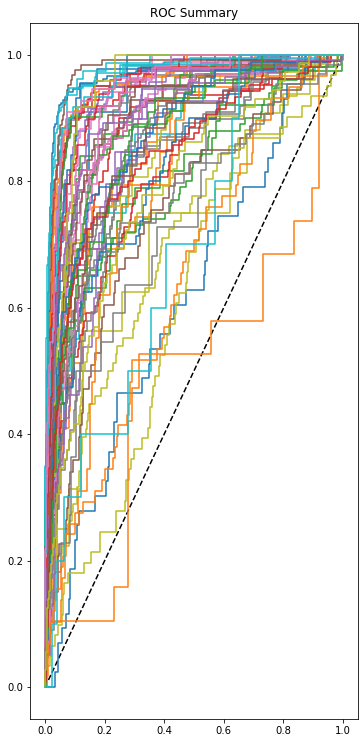

In [2]:
plt.figure(figsize=(27.0,12.8))

# Initalize ROC-curve tile
plt.subplot2grid((1,4),(0,0))
plt.title('ROC Summary')
plt.plot([0,1],[0,1],'k--')

for i, tpr in enumerate(tprs):
    fpr = fprs[i]
    try:
        plt.plot(fpr, tpr)
    except:
        pass
plt.show()